Differentiators in PySINDy

This notebook explores the differentiation methods available in PySINDy. Most of the methods are powered by the [derivative](https://pypi.org/project/derivative/) package. While this notebook explores these methods on temporal data, these apply equally well to the computation of spatial derivatives for SINDy for PDE identification (see example Jupyter notebooks 10 and 12, on PDEs and weak forms).
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.7?filepath=examples/5_differentiation.ipynb)

In [2]:
import warnings

import matplotlib.pyplot as plt

plt.ion()
import numpy as np

import pysindy as ps

# ignore user warnings
warnings.filterwarnings("ignore", category=UserWarning)

integrator_keywords = {}
integrator_keywords["rtol"] = 1e-12
integrator_keywords["method"] = "LSODA"
integrator_keywords["atol"] = 1e-12

from utils import (
    compare_methods,
    print_equations,
    compare_coefficient_plots,
    plot_sho,
    plot_lorenz,
)

if __name__ != "testing":
    from example_data import (
        gen_data_sine,
        gen_data_step,
        gen_data_sho,
        gen_data_lorenz,
        n_spectral,
        fd_order,
    )
else:
    from mock_data import (
        gen_data_sine,
        gen_data_step,
        gen_data_sho,
        gen_data_lorenz,
        n_spectral,
        fd_order,
    )


In the cell below we define all the available differentiators. Note that the different options in `SINDyDerivative` all originate from `derivative`.

* `FiniteDifference` - First order (forward difference) or second order (centered difference) finite difference methods with the ability to drop endpoints. Does *not* assume a uniform time step. Appropriate for smooth data.
* `finite_difference` - Central finite differences of any order. Assumes a uniform time step. Appropriate for smooth data.
* `Smoothed Finite Difference` - `FiniteDifference` with a smoother (default is Savitzky Golay) applied to the data before differentiation. Appropriate for noisy data.
* `savitzky_golay` - Perform a least-squares fit of a polynomial to the data, then compute the derivative of the polynomial. Appropriate for noisy data.
* `spline` - Fit the data with a spline (of arbitrary order) then perform differentiation on the spline. Appropriate for noisy data.
* `trend_filtered` - Use total squared variations to fit the data (computes a global derivative that is a piecewise combination of polynomials of a chosen order). Set `order=0` to obtain the total-variational derivative. Appropriate for noisy data
* `spectral` - Compute the spectral derivative of the data via Fourier Transform. Appropriate for very smooth (i.e. analytic) data. There is an in-house PySINDy version for speed but this is also included in the derivative package.

In [3]:


diffs = [
    ("PySINDy Finite Difference", ps.FiniteDifference()),
    ("Finite Difference", ps.SINDyDerivative(kind="finite_difference", k=1)),
    ("Smoothed Finite Difference", ps.SmoothedFiniteDifference()),
    (
        "Savitzky Golay",
        ps.SINDyDerivative(kind="savitzky_golay", left=0.5, right=0.5, order=3),
    ),
    ("Spline", ps.SINDyDerivative(kind="spline", s=1e-2)),
    ("Trend Filtered", ps.SINDyDerivative(kind="trend_filtered", order=0, alpha=1e-2)),
    ("Spectral", ps.SINDyDerivative(kind="spectral")),
    ("Spectral, PySINDy version", ps.SpectralDerivative()),
    ("Kalman", ps.SINDyDerivative(kind="kalman", alpha=0.05)),
]




## Compare differentiation methods directly
First we'll use the methods to numerically approximate derivatives to measurement data directly, without bringing SINDy into the picture. We'll compare the different methods' accuracies when working with clean data ("approx" in the plots) and data with a small amount of white noise ("noisy").

In [4]:


noise_level = 0.01


# ### Sine

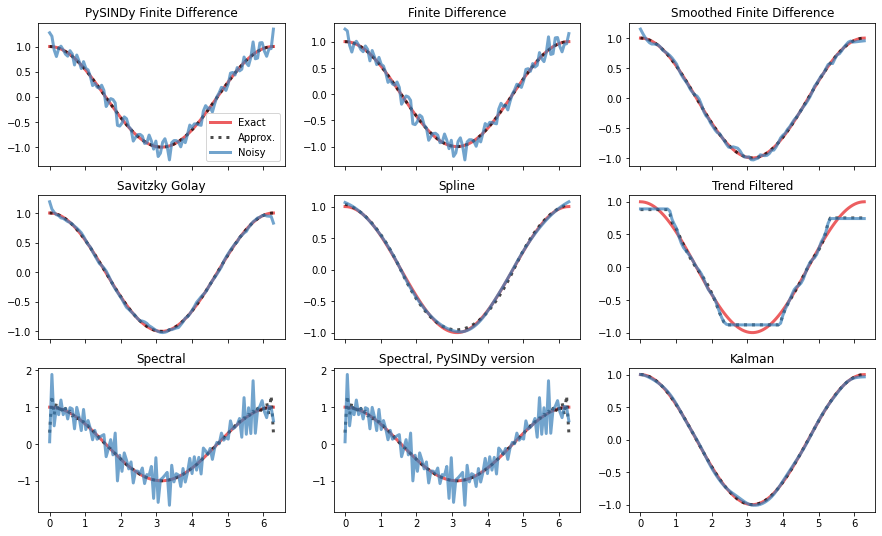

In [5]:


# True data
x, y, y_noisy, y_dot = gen_data_sine(noise_level)
axs = compare_methods(diffs, x, y, y_noisy, y_dot)
plt.show()


# ### Absolute value

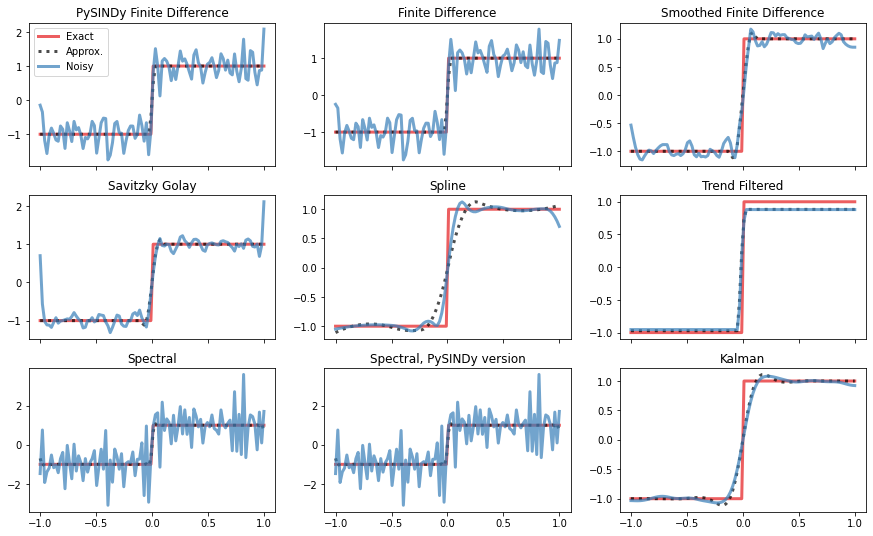

In [6]:


# Shrink window for Savitzky Golay method
diffs[3] = (
    "Savitzky Golay",
    ps.SINDyDerivative(kind="savitzky_golay", left=0.1, right=0.1, order=3),
)
diffs[8] = ("Kalman", ps.SINDyDerivative(kind="kalman", alpha=0.01))

x, y, y_dot, y_noisy = gen_data_step(noise_level)

axs = compare_methods(diffs, x, y, y_noisy, y_dot)
plt.show()




## Compare differentiators when used in PySINDy
We got some idea of the performance of the differentiation options applied to raw data. Next we'll look at how they work as a single component of the SINDy algorithm.

### Linear oscillator
$$ \frac{d}{dt} \begin{bmatrix}x \\ y\end{bmatrix} = \begin{bmatrix} -0.1 & 2 \\ -2 & -0.1 \end{bmatrix} \begin{bmatrix}x \\ y\end{bmatrix} $$

+


In [7]:


noise_level = 0.1

In [8]:


# Generate training data

dt, t_train, x_train, x_train_noisy = gen_data_sho(noise_level, integrator_keywords)

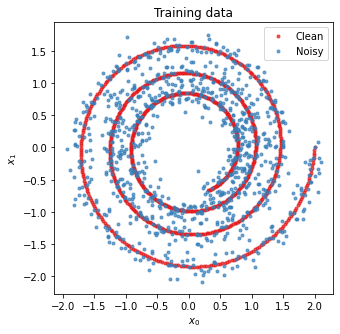

In [9]:
figure = plt.figure(figsize=[5, 5])
plot_sho(x_train, x_train_noisy)

# Allow Trend Filtered method to work with linear functions
diffs[5] = (
    "Trend Filtered",
    ps.SINDyDerivative(kind="trend_filtered", order=1, alpha=1e-2),
)
diffs[8] = ("Kalman", ps.SINDyDerivative(kind="kalman", alpha=0.5))
diffs.append(("Smooth FD, reuse old x", ps.SmoothedFiniteDifference(save_smooth=False)))
diffs.append(
    (
        "Kalman, reuse old x",
        ps.SINDyDerivative(kind="kalman", alpha=0.5, save_smooth=False),
    )
)

equations_clean = {}
equations_noisy = {}
coefficients_clean = {}
coefficients_noisy = {}
input_features = ["x", "y"]
threshold = 0.5

for name, method in diffs:
    model = ps.SINDy(
        differentiation_method=method,
        optimizer=ps.STLSQ(threshold=threshold),
        t_default=dt,
        feature_names=input_features,
    )

    model.fit(x_train, quiet=True)
    equations_clean[name] = model.equations()
    coefficients_clean[name] = model.coefficients()

    model.fit(x_train_noisy, quiet=True)
    equations_noisy[name] = model.equations()
    coefficients_noisy[name] = model.coefficients()

In [10]:


print_equations(equations_clean, equations_noisy)

                               Noiseless                                Noisy                                   
PySINDy Finite Difference                                                                                       
                               x0=2.006 y                               x0=2.034 y                              
                               x1=-1.994 x                              x1=-2.033 x                             
-------------------------------------------------------------------------------------------
Finite Difference                                                                                               
                               x0=2.006 y                               x0=2.034 y                              
                               x1=-1.994 x                              x1=-2.042 x                             
-------------------------------------------------------------------------------------------
Smoothed Finite Differenc

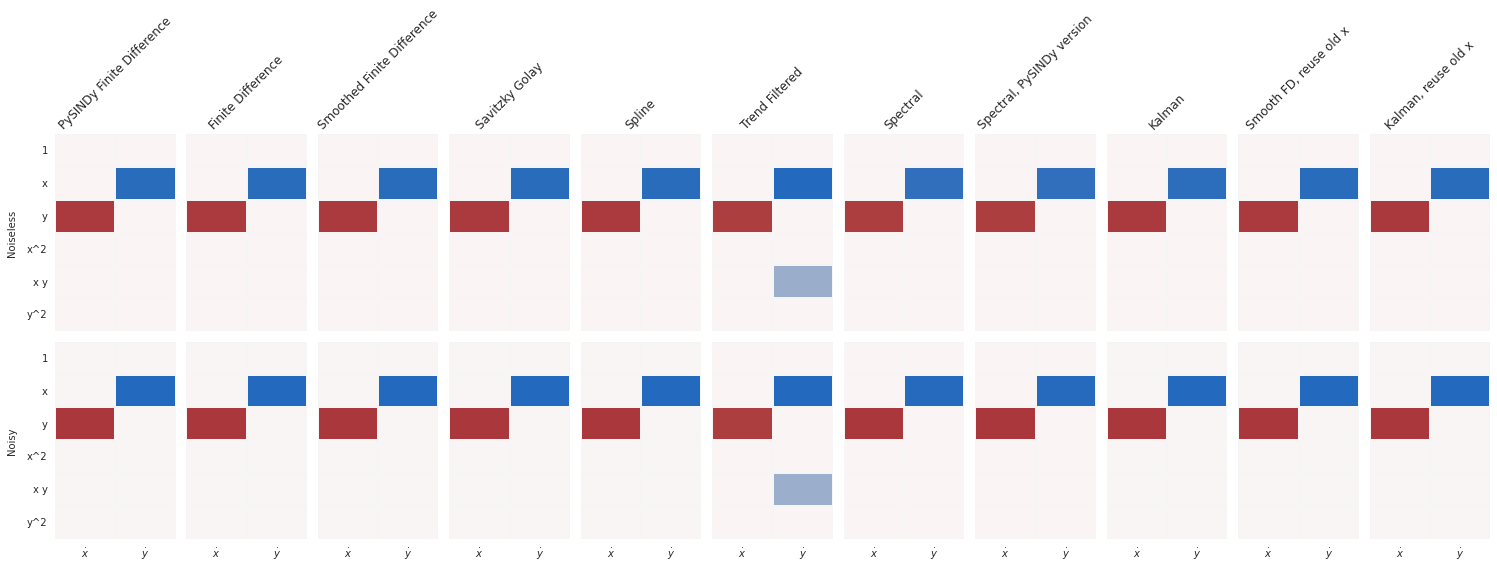

In [11]:


feature_names = model.get_feature_names()
compare_coefficient_plots(
    coefficients_clean,
    coefficients_noisy,
    input_features=input_features,
    feature_names=feature_names,
)
plt.show()


We can take a look at the smoothed values of x that some differentiation
methods implicitly calculate:

Text(0.5, 1.0, 'Kalman smoothed')

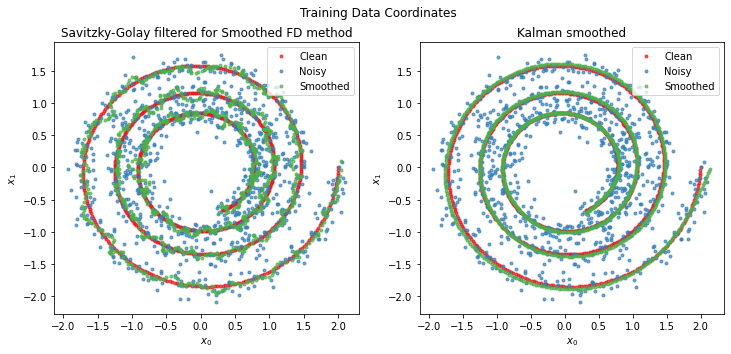

In [12]:
fig = plt.figure(figsize=[12, 5])
fig.suptitle("Training Data Coordinates")
plt.subplot(1, 2, 1)
ax = plot_sho(x_train, x_train_noisy, diffs[2][1].smoothed_x_)
ax.set_title("Savitzky-Golay filtered for Smoothed FD method")
plt.subplot(1, 2, 2)
ax = plot_sho(x_train, x_train_noisy, diffs[8][1].smoothed_x_)
ax.set_title("Kalman smoothed")

### Lorenz system

$$ \begin{aligned} \dot x &= 10(y-x)\\ \dot y &= x(28 - z) - y \\ \dot z &= xy - \tfrac{8}{3} z, \end{aligned} $$


In [13]:


noise_level = 0.5

In [14]:


# Generate measurement data
dt, t_train, x_train, x_train_noisy = gen_data_lorenz(noise_level, integrator_keywords)

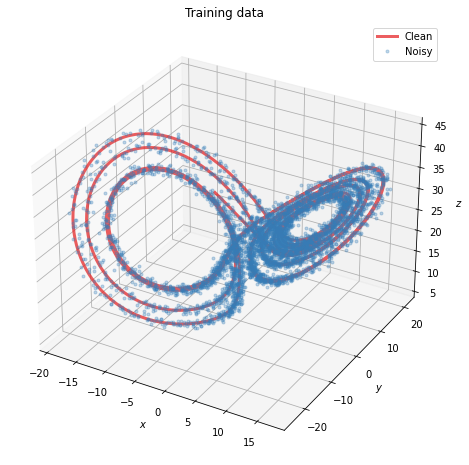

In [15]:


fig = plt.figure(figsize=(8, 8))
plot_lorenz(x_train, x_train_noisy)
fig.show()

In [16]:
diffs[8] = ("Kalman", ps.SINDyDerivative(kind="kalman", alpha=0.0015))
diffs[10] = (
    "Kalman, reuse old x",
    ps.SINDyDerivative(kind="kalman", alpha=0.0015, save_smooth=False),
)

equations_clean = {}
equations_noisy = {}
coefficients_clean = {}
coefficients_noisy = {}
input_features = ["x", "y", "z"]

threshold = 0.5

for name, method in diffs:
    model = ps.SINDy(
        differentiation_method=method,
        optimizer=ps.STLSQ(threshold=threshold),
        t_default=dt,
        feature_names=input_features,
    )

    model.fit(x_train, quiet=True)
    equations_clean[name] = model.equations()
    coefficients_clean[name] = model.coefficients()

    model.fit(x_train_noisy, quiet=True)
    equations_noisy[name] = model.equations()
    coefficients_noisy[name] = model.coefficients()

In [17]:


print_equations(equations_clean, equations_noisy)

                               Noiseless                                Noisy                                   
PySINDy Finite Difference                                                                                       
                               x0=-9.999 x + 9.999 y                    x0=-9.937 x + 9.968 y                   
                               x1=27.992 x + -0.999 y + -1.000 x z      x1=0.651 1 + 24.904 x + -0.933 x z      
                               x2=-2.666 z + 1.000 x y                  x2=-2.632 z + 0.994 x y                 
-------------------------------------------------------------------------------------------
Finite Difference                                                                                               
                               x0=-9.999 x + 9.999 y                    x0=-9.873 x + 9.907 y                   
                               x1=27.993 x + -0.999 y + -1.000 x z      x1=0.633 1 + 24.937 x + -0.933 x z      
    

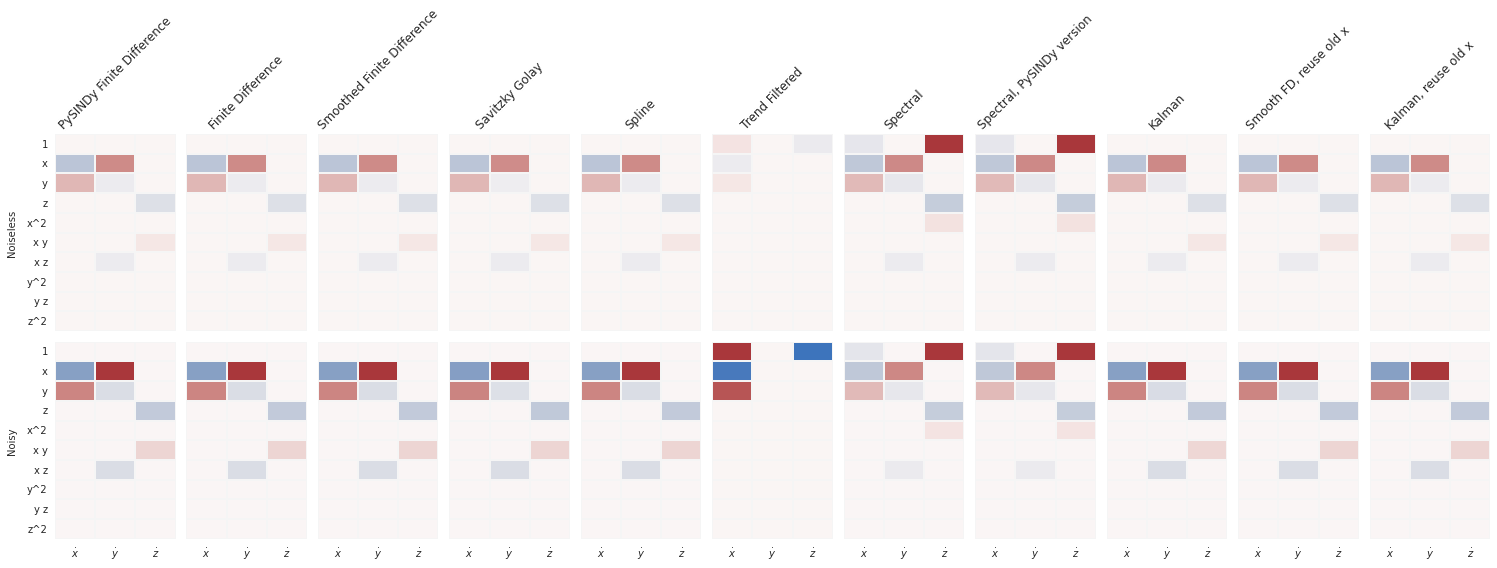

In [18]:


feature_names = model.get_feature_names()
compare_coefficient_plots(
    coefficients_clean,
    coefficients_noisy,
    input_features=input_features,
    feature_names=feature_names,
)
plt.show()

Text(0.5, 0.92, 'Kalman smoothed')

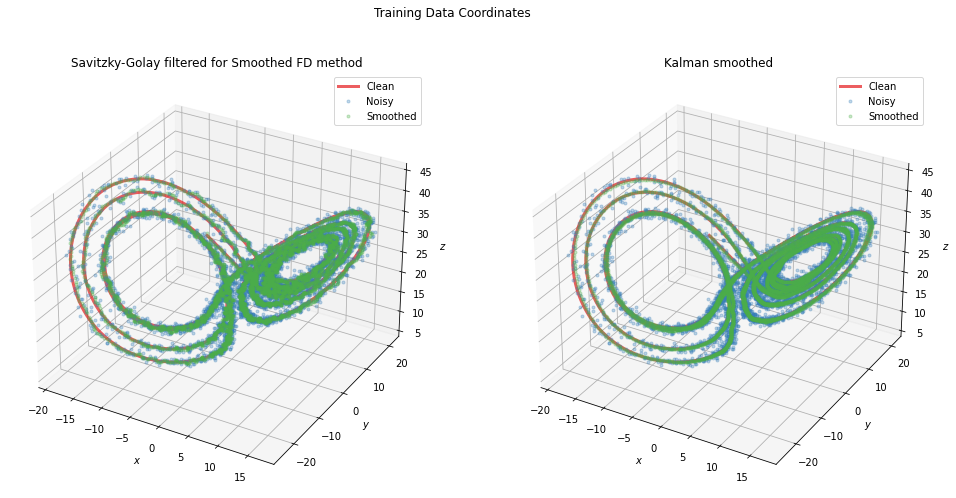

In [19]:
fig = plt.figure(figsize=(16.5, 8))
fig.suptitle("Training Data Coordinates")
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax = plot_lorenz(x_train, x_train_noisy, diffs[2][1].smoothed_x_, ax=ax)
ax.set_title("Savitzky-Golay filtered for Smoothed FD method")
ax = fig.add_subplot(1, 2, 2, projection="3d")
ax = plot_lorenz(x_train, x_train_noisy, diffs[8][1].smoothed_x_, ax=ax)
ax.set_title("Kalman smoothed")

In [20]:
import timeit

N_spectral = np.logspace(1, 8, n_spectral, dtype=int)
spectral_times = np.zeros((n_spectral, 2))
for i in range(n_spectral):
    # True data
    x = np.linspace(0, 2 * np.pi, N_spectral[i])
    y = np.sin(x)
    y_dot = np.cos(x)
    noise_level = 0.05
    y_noisy = y + noise_level * np.random.randn(len(y))

    start = timeit.default_timer()
    spectral1 = ps.SINDyDerivative(kind="spectral")(y_noisy, x)
    stop = timeit.default_timer()
    spectral_times[i, 0] = stop - start

    start = timeit.default_timer()
    spectral2 = ps.SpectralDerivative(y_noisy, x)
    stop = timeit.default_timer()
    spectral_times[i, 1] = stop - start

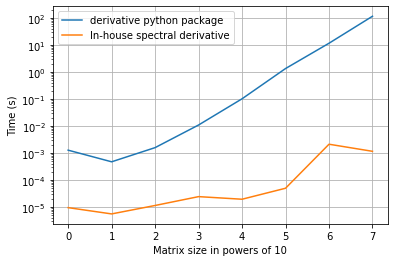

In [21]:


plt.figure()
plt.grid(True)
plt.semilogy(spectral_times[:, 0], label="derivative python package")
plt.semilogy(spectral_times[:, 1], label="In-house spectral derivative")
plt.ylabel("Time (s)")
plt.xlabel("Matrix size in powers of 10")
plt.legend()
plt.show()

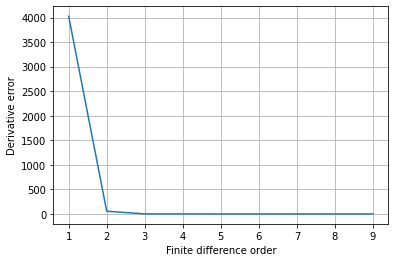

In [22]:


# Check error improves as order increases
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x) - x**5
y_dot = np.cos(x) - 5 * x**4
err = np.zeros(9)
for order in range(1, fd_order + 1):
    diff = ps.FiniteDifference(d=1, order=order)
    diff = diff(y, x)
    err[order - 1] = np.sum(np.abs(y_dot - diff))
plt.figure()
plt.plot(range(1, 10), err)
plt.grid(True)
plt.ylabel("Derivative error")
plt.xlabel("Finite difference order")
plt.show()